http://kvfrans.com/variational-autoencoders-explained/

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples[:16]):
        sample = np.array(sample)
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [16]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)
# def xavier_init(fan_in, fan_out, constant=1): 
#     """ Xavier initialization of network weights"""
#     # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
#     low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
#     high = constant*np.sqrt(6.0/(fan_in + fan_out))
#     return tf.random_uniform((fan_in, fan_out), 
#                              minval=low, maxval=high, 
#                              dtype=tf.float32)

In [21]:
# fully-conected layer
def dense(x, inputFeatures, outputFeatures, scope=None, with_w=False):
    matrix = tf.Variable(xavier_init([inputFeatures, outputFeatures]))
    bias = tf.Variable( tf.zeros(shape = [outputFeatures]))
    if with_w:
        return tf.matmul(x, matrix) + bias, matrix, bias
    else:
        return tf.matmul(x, matrix) + bias

In [103]:
n_z = 20
batchsize = 32

# ENCODER
X = tf.placeholder(tf.float32, shape=[None, 784])
def encoder(x):
    with tf.variable_scope("encoder"):
        E_1 = tf.nn.relu(dense(x, 784, 128))
        E_2 = tf.nn.relu(dense(E_1, 128, 128))
        z_mean = dense(E_2, 128, n_z)
        z_stddev = dense(E_2, 128, n_z)
    return z_mean, z_stddev

# DECODER
def decoder(z):
    with tf.variable_scope("decoder"):
        D_1 = tf.nn.relu(dense(z, n_z, 128))
        D_log_prob = dense(D_1, 128, 784)
        D_prob = tf.nn.sigmoid(D_log_prob)
    return D_prob



z_mean, z_stddev = encoder(X)

samples = tf.random_normal([batchsize, n_z], 0, 1, dtype=tf.float32)
z_code = z_mean + (z_stddev * samples)

generated_images = decoder(z_code)


# LOSS
generation_loss = -tf.reduce_sum(X * tf.log(1e-8 + generated_images) + 
                                 (1-X) * tf.log(1e-8 + 1 - generated_images)
                                 ,1)
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1,1)
loss = tf.reduce_mean(generation_loss + latent_loss)

optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [104]:
samples_fake = tf.random_normal([16, n_z], 0, 1, dtype=tf.float32)
fake_images = decoder(samples_fake)

In [105]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [106]:
mb_size = batchsize
for it in range(90000):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, gen_loss, lat_loss = sess.run((optimizer, generation_loss, latent_loss), 
                                     feed_dict={X: X_mb})
    if it % 10000 == 0:
        print('Iter: {}'.format(it))
        print('gen_loss: {:.4}'. format(np.mean(gen_loss)))
        print('lat_loss: {:.4}'.format(np.mean(lat_loss)))
        print()

Iter: 0
gen_loss: 645.1
lat_loss: 20.86

Iter: 10000
gen_loss: 151.8
lat_loss: 33.03

Iter: 20000
gen_loss: 129.3
lat_loss: 26.66

Iter: 30000
gen_loss: 158.9
lat_loss: 24.78

Iter: 40000
gen_loss: 131.5
lat_loss: 30.17

Iter: 50000
gen_loss: 140.9
lat_loss: 28.5

Iter: 60000
gen_loss: 139.5
lat_loss: 30.42

Iter: 70000
gen_loss: 142.8
lat_loss: 33.42

Iter: 80000
gen_loss: 138.0
lat_loss: 25.19



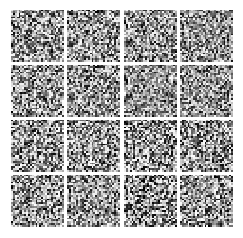

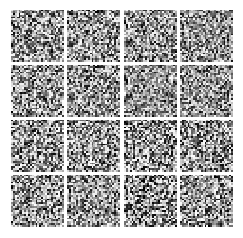

In [107]:
plot(sess.run(fake_images,feed_dict={X: X_mb}))